In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2021-ai-w10-p1/2021-ai-w10-p1/train.csv
/kaggle/input/2021-ai-w10-p1/2021-ai-w10-p1/test.csv
/kaggle/input/2021-ai-w10-p1/2021-ai-w10-p1/sample_submit.csv


In [2]:
import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import random

random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

In [3]:
train = pd.read_csv("/kaggle/input/2021-ai-w10-p1/2021-ai-w10-p1/train.csv")
test = pd.read_csv("/kaggle/input/2021-ai-w10-p1/2021-ai-w10-p1/test.csv")
submit = pd.read_csv("/kaggle/input/2021-ai-w10-p1/2021-ai-w10-p1/sample_submit.csv")

In [4]:
train.head()

,Category,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train = train.drop('Category', axis = 1)
y_train = train['Category']

# threshold = 100
# X_train[X_train<threshold] = 0
# X_test = (test>threshold).astype('int')

X_train /= 255
X_test = test / 255
    
X_train = torch.FloatTensor(X_train.to_numpy()).reshape(-1,1, 28, 28).cuda()
y_train = torch.LongTensor(y_train.to_numpy()).cuda()
X_test = torch.FloatTensor(X_test.to_numpy()).reshape(-1,1, 28, 28).cuda()

In [6]:
dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset = dataset,
                                        batch_size = 20, #메모리 때문에 줄임
                                        shuffle = True,
                                        drop_last = True)
n_batch = len(dataloader)

test_dataset = torch.utils.data.TensorDataset(X_test, torch.zeros(X_test.shape[0])) # torch.utils.data.TensorDataset(X_test)로 하면 .repeat이 안됨.
test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = 20, 
                                        shuffle = False,
                                        drop_last = False)

In [7]:
def preprocess(X):
#     preprocess = torch.nn.Sequential(transforms.Resize((299,299), interpolation = torchvision.transforms.InterpolationMode.NEAREST),
#                                      transforms.CenterCrop)_
#                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])).cuda()
    out = X.repeat(1,3,1,1)
    out = transforms.Resize((299,299), interpolation = transforms.InterpolationMode.NEAREST)(out) 
    out = transforms.CenterCrop(224)(out) 
    out = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(out)
    
    return out

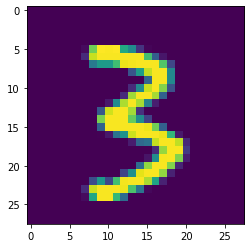

In [8]:
#original
import matplotlib.pyplot as plt
r = random.randint(0, 10)
X_single_data = X_train[r].float()
plt.imshow(X_single_data.reshape(28,28).cpu())

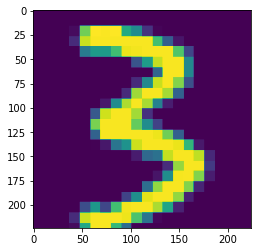

In [9]:
# resized and cropped (성능 향상 됐음)
X_single_data = X_train[r].float()
plt.imshow(preprocess(X_single_data)[0][0].reshape(224,224).cpu())

# 1 ResNet18, 50, 101 - 베이스라인 성능 도달 X

In [10]:
model = torchvision.models.resnet18(pretrained = True).cuda()

model.fc.out_features = 10
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

torch.nn.init.xavier_normal_(model.fc.weight)
        
loss = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

for epoch in range(20):
    model.train()
    avg_cost = 0
    avg_acc = 0
    for i, data in enumerate(dataloader):
        X, Y = data[0], data[1]
        h = model(preprocess(X))
        cost = loss(h, Y)        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        avg_cost += cost.item()
    print(epoch+1, (avg_cost/n_batch))
    scheduler.step()
    

end.record()
torch.cuda.synchronize()
print("time:", start.elapsed_time(end)/60000, "m")
print("finish!")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

1 0.5155386972874403
2 0.30049775826372205
3 0.2672884688495348
4 0.25522036602611964
5 0.24220402648548287
6 0.20942731110254922
7 0.20886561917575697
8 0.20630320604735364
9 0.20462625359743833
10 0.20728205798907826
11 0.2014728368325159
12 0.19949552207036564
13 0.20241461133708558
14 0.20168699780789515
15 0.20137838541017844
16 0.2004190231661002
17 0.20052878713048994
18 0.20223767889632532
19 0.20148718560890605
20 0.2031726372622264
time: 12.427096875 m
finish!


In [11]:
y_pred = []
for xx, yy in test_dataloader:
    model.eval()
    h = model(preprocess(xx))
    pred = torch.argmax(h, 1).cpu().detach().numpy()
    y_pred.extend(pred)

y_pred = np.array(y_pred)

submit['Category'] = y_pred
submit.to_csv("submission_ResNet18.csv", mode='w', index=False)
submit

,Id,Category
0,0,6
1,1,1
2,2,0
3,3,0
4,4,9
...,...,...
9995,9995,3
9996,9996,7
9997,9997,2
9998,9998,8


# 1-1. ResNet + New net

In [12]:
#trained model 가져오기 
pretrained_model = torchvision.models.resnet18(pretrained = True).cuda()

#freeze
for param in pretrained_model.parameters():
    param.requires_grad = False

#학습 layer 추가 
linear1 = torch.nn.Linear(1000, 512).cuda()
linear2 = torch.nn.Linear(512, 128).cuda()
linear3 = torch.nn.Linear(128, 10).cuda()
torch.nn.init.xavier_normal_(linear1.weight)
torch.nn.init.xavier_normal_(linear2.weight)
torch.nn.init.xavier_normal_(linear3.weight)

relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p = 0.2)

model = torch.nn.Sequential(pretrained_model, relu, #dropout,
                            linear1, relu, #dropout,
                            linear2, relu, #dropout,
                           linear3).cuda()

In [13]:
loss = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()


for epoch in range(30):
    model.train()
    avg_cost = 0
    avg_acc = 0
    for i, data in enumerate(dataloader):
        X, Y = data[0], data[1]
        h = model(preprocess(X))
        cost = loss(h, Y)        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        avg_cost += cost.item()
    print(epoch+1, (avg_cost/n_batch))
    scheduler.step()
    
end.record()
torch.cuda.synchronize()
print("time:", start.elapsed_time(end)/60000, "m")
print("finish!")

1 0.4898305079974234
2 0.33056311516774195
3 0.28163255634034673
4 0.2539064952062132
5 0.22637101222613515
6 0.1664185693777593
7 0.14902012736188772
8 0.1380984110792124
9 0.1281832710695841
10 0.11905968038811018
11 0.09122833255855949
12 0.0849283867226671
13 0.07658041834394923
14 0.075815325112555
15 0.07418542021554216
16 0.06005407837339226
17 0.054335694062655114
18 0.05367215986181327
19 0.05182974415011813
20 0.05077765226958581
21 0.04285763543063846
22 0.04244900486770871
23 0.04075676968535026
24 0.04095278305804686
25 0.0409674165417661
26 0.03859972501617479
27 0.033859342491262094
28 0.035899735739821914
29 0.034796962157030216
30 0.03214064171702057
time: 18.861245833333335 m
finish!


In [14]:
y_pred = []
for xx, yy in test_dataloader:
    model.eval()
    h = model(preprocess(xx))
    pred = torch.argmax(h, 1).cpu().detach().numpy()
    y_pred.extend(pred)

y_pred = np.array(y_pred)

submit['Category'] = y_pred
submit.to_csv("submission_ResNet18_additive.csv", mode='w', index=False)
submit

,Id,Category
0,0,6
1,1,1
2,2,0
3,3,0
4,4,9
...,...,...
9995,9995,3
9996,9996,7
9997,9997,2
9998,9998,8


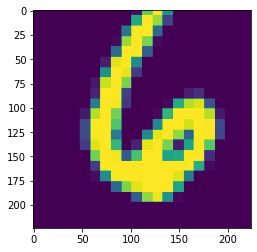

In [15]:
X_single_data = X_test[0].float()
plt.imshow(preprocess(X_single_data)[0][0].reshape(224,224).cpu())

# 1-3 Freeze 하지 않고, 전체 파라미터를 학습

In [16]:
#trained model 가져오기 
pretrained_model = torchvision.models.resnet18(pretrained = True).cuda()
for param in pretrained_model.parameters():
    param.requires_grad = True

#layer 추가 
linear1 = torch.nn.Linear(1000, 512).cuda()
linear2 = torch.nn.Linear(512, 128).cuda()
linear3 = torch.nn.Linear(128, 10).cuda()
torch.nn.init.xavier_normal_(linear1.weight)
torch.nn.init.xavier_normal_(linear2.weight)
torch.nn.init.xavier_normal_(linear3.weight)

model = torch.nn.Sequential(pretrained_model, relu, #dropout,
                            linear1, relu, #dropout,
                            linear2, relu, #dropout,
                           linear3).cuda()

In [17]:
loss = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) 
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()


for epoch in range(10):
    model.train()
    avg_cost = 0
    avg_acc = 0
    for i, data in enumerate(dataloader):
        X, Y = data[0], data[1]
        h = model(preprocess(X))
        cost = loss(h, Y)        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        avg_cost += cost.item()
    print(epoch+1, (avg_cost/n_batch))
    scheduler.step()
    
end.record()
torch.cuda.synchronize()
print("time:", start.elapsed_time(end)/60000, "m")
print("finish!")

1 0.1434678825468921
2 0.07566356688660895
3 0.058354611527146515
4 0.04887761678969999
5 0.042543478045861755
6 0.02133413726156175
7 0.017381713200713564
8 0.015611365487400629
9 0.014161313965708246
10 0.013141799881407403
time: 20.284091666666665 m
finish!


In [18]:
y_pred = []
for xx, yy in test_dataloader:
    model.eval()
    h = model(preprocess(xx))
    pred = torch.argmax(h, 1).cpu().detach().numpy()
    y_pred.extend(pred)

y_pred = np.array(y_pred)

submit['Category'] = y_pred
submit.to_csv("submission_ResNet18_train_entire.csv", mode='w', index=False)
submit

,Id,Category
0,0,6
1,1,1
2,2,0
3,3,0
4,4,9
...,...,...
9995,9995,3
9996,9996,7
9997,9997,2
9998,9998,8
